In [1]:
from datasets import Dataset, Audio, DatasetDict
import pandas as pd
import os

# Define paths
dataset_dir = "/home/hkngae/COMP5412/data/NoisySpeechDataset"
metadata_file = os.path.join(dataset_dir, "metadata.csv")
first_n = 1000  # Number of examples to load for trial

# Check if metadata file exists and read its structure first
if os.path.exists(metadata_file):
    # Just peek at the first few rows to see the structure
    print("Metadata file columns:")
    print(pd.read_csv(metadata_file, nrows=1).columns.tolist())

    # Load only the first n examples from metadata for trial
    metadata_df = pd.read_csv(metadata_file).head(first_n)
    
    # Assuming columns like "noisy_file", "clean_file", "snr" exist
    # Adapt these column names to match your actual metadata structure
    dataset_dict = {
        "id": [str(i) for i in range(len(metadata_df))],
        "noisy_file": metadata_df["noisy_file"].tolist() if "noisy_file" in metadata_df.columns else [],
        "clean_file": metadata_df["clean_file"].tolist() if "clean_file" in metadata_df.columns else [],
        "snr": metadata_df["snr"].tolist() if "snr" in metadata_df.columns else []
    }
    
    # Create the dataset
    small_ds = Dataset.from_dict(dataset_dict)
    
    # Add audio loading functionality 
    if "noisy_file" in metadata_df.columns:
        small_ds = small_ds.cast_column("noisy_file", Audio(sampling_rate=16000))
    if "clean_file" in metadata_df.columns:
        small_ds = small_ds.cast_column("clean_file", Audio(sampling_rate=16000))
    
    # Inspect the small dataset
    print(f"Small dataset contains {len(small_ds)} examples")
    print(f"Features: {small_ds.features}")
    
else:
    print(f"Metadata file not found at {metadata_file}")
    print("Please check the path or create the metadata file.")

/home/hkngae/anaconda3/envs/COMP5412/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Metadata file columns:
['noisy_file', 'clean_file', 'noise_file', 'snr']
Small dataset contains 1000 examples
Features: {'id': Value(dtype='string', id=None), 'noisy_file': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'clean_file': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'snr': Value(dtype='int64', id=None)}


Noisy audio sample rate: 16000 Hz
Noisy audio duration: 7.64 seconds


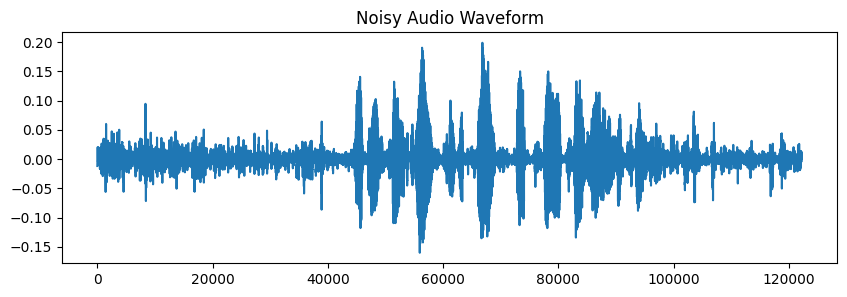

Noisy Audio:



Clean audio sample rate: 16000 Hz
Clean audio duration: 7.64 seconds


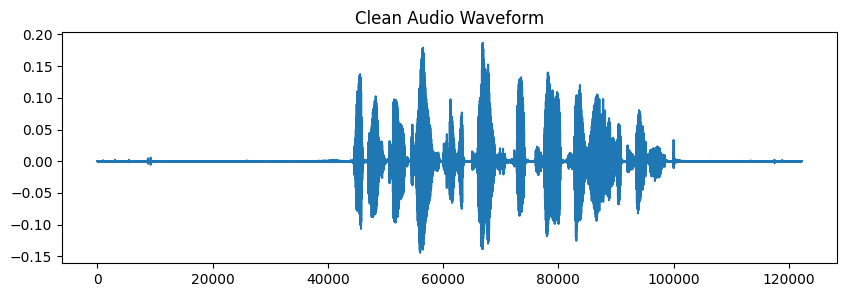

Clean Audio:


In [2]:
from IPython.display import Audio, display
import matplotlib.pyplot as plt

# Get a sample from the dataset
sample_idx = 9  # Change this to listen to different samples
if len(small_ds) > sample_idx:
    sample = small_ds[sample_idx]
    
    # Get the audio arrays and sampling rate
    if "noisy_file" in sample:
        noisy_audio = sample["noisy_file"]["array"]
        sr = sample["noisy_file"]["sampling_rate"]
        print(f"Noisy audio sample rate: {sr} Hz")
        print(f"Noisy audio duration: {len(noisy_audio)/sr:.2f} seconds")
        
        # Display waveform
        plt.figure(figsize=(10, 3))
        plt.plot(noisy_audio)
        plt.title("Noisy Audio Waveform")
        plt.show()
        
        # Create audio player
        print("Noisy Audio:")
        display(Audio(noisy_audio, rate=sr))
    
    if "clean_file" in sample:
        clean_audio = sample["clean_file"]["array"]
        sr = sample["clean_file"]["sampling_rate"]
        print(f"\nClean audio sample rate: {sr} Hz")
        print(f"Clean audio duration: {len(clean_audio)/sr:.2f} seconds")
        
        # Display waveform
        plt.figure(figsize=(10, 3))
        plt.plot(clean_audio)
        plt.title("Clean Audio Waveform")
        plt.show()
        
        # Create audio player
        print("Clean Audio:")
        display(Audio(clean_audio, rate=sr))
else:
    print("No samples available to play.")

In [3]:
from mydatasets.rawAudioDenoisingDataset import RawAudioDenoisingDataset
from torch.utils.data import DataLoader

# Create train/val/test splits
train_ds, test_ds = small_ds.train_test_split(test_size=0.2, seed=42).values()
train_ds, val_ds = train_ds.train_test_split(test_size=0.25, seed=42).values()

# Set a fixed length for training (e.g., 2 seconds of audio at 16kHz = 32000 samples)
# Or set to None to keep variable length with padding in batches
fixed_length = None  # 32000  # Use a fixed length like this, or None for variable length

# Create datasets
train_dataset = RawAudioDenoisingDataset(train_ds, fixed_length=fixed_length, augment=True)
val_dataset = RawAudioDenoisingDataset(val_ds, fixed_length=fixed_length)
test_dataset = RawAudioDenoisingDataset(test_ds, fixed_length=fixed_length)

# Create data loaders
batch_size = 2
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    collate_fn=RawAudioDenoisingDataset.variable_length_collate if fixed_length is None else None
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    collate_fn=RawAudioDenoisingDataset.variable_length_collate if fixed_length is None else None
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    collate_fn=RawAudioDenoisingDataset.variable_length_collate if fixed_length is None else None
)

# Verify a batch
for batch in train_loader:
    print(f"Noisy audio shape: {batch['noisy'].shape}")
    print(f"Clean audio shape: {batch['clean'].shape}")
    if fixed_length is None:
        print(f"Sequence lengths: {batch['lengths']}")
    break

Noisy audio shape: torch.Size([2, 138560])
Clean audio shape: torch.Size([2, 138560])
Sequence lengths: tensor([126240, 138560])


Dataset sizes:
Train: 600 samples
Validation: 200 samples
Test: 200 samples

Raw audio sample:
Noisy audio shape: torch.Size([122240])
Clean audio shape: torch.Size([122240])

Batch info:
Noisy batch shape: torch.Size([2, 138560])
Clean batch shape: torch.Size([2, 138560])


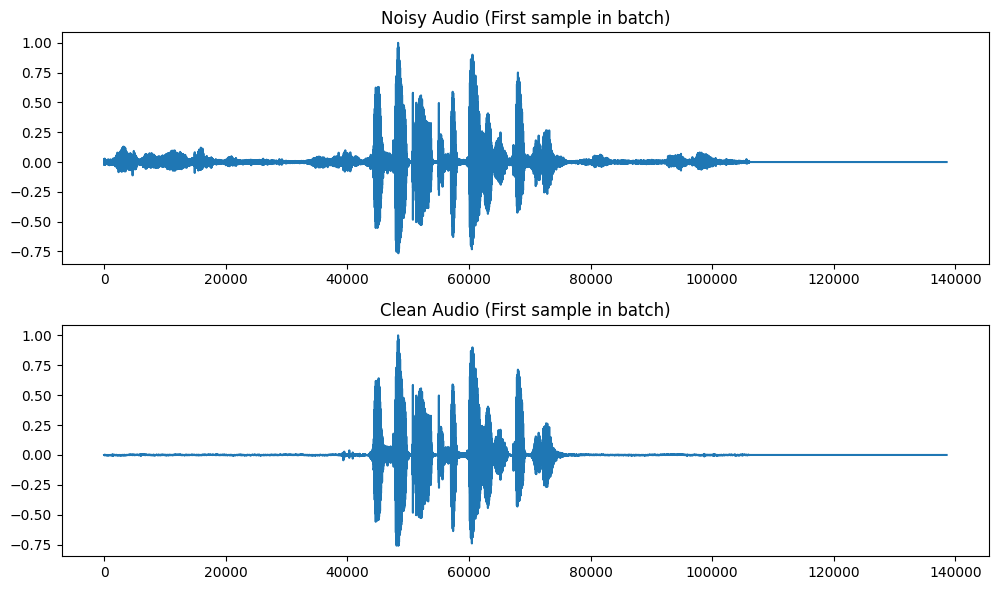

In [4]:
# Test the dataset loaders
print("Dataset sizes:")
print(f"Train: {len(train_dataset)} samples")
print(f"Validation: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

# Get and inspect a sample from the training dataset
sample = train_dataset[0]
print("\nRaw audio sample:")
print(f"Noisy audio shape: {sample['noisy'].shape}")
print(f"Clean audio shape: {sample['clean'].shape}")

# Visualize a training batch
for batch in train_loader:
    print("\nBatch info:")
    print(f"Noisy batch shape: {batch['noisy'].shape}")
    print(f"Clean batch shape: {batch['clean'].shape}")
    
    # Plot the first sample in the batch
    plt.figure(figsize=(10, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(batch['noisy'][0].numpy())
    plt.title("Noisy Audio (First sample in batch)")
    
    plt.subplot(2, 1, 2)
    plt.plot(batch['clean'][0].numpy())
    plt.title("Clean Audio (First sample in batch)")
    
    plt.tight_layout()
    plt.show()
    break

In [5]:
from models.myModel.my_model import InceptionFCN
from models.waveUNet.waveunet import Waveunet
from torch import nn
import torch.multiprocessing as mp
from training.ddp_trainer import run_ddp_training


In [6]:
import torch
#Allowing loading any model architecture
# Test with a sample batch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create and initialize the model

#model = InceptionFCN(residual_learning=True).to(device)

model = Waveunet(
    num_inputs=1,                    # Mono speech is common
    num_channels=[32, 64, 128, 256, 512, 1024],  # 6 levels with doubling features
    num_outputs=1,                   # Output clean speech
    instruments=["speech"],          # Single target
    kernel_size=15,                  # Larger kernel for better frequency resolution
    conv_type="gn",                  # Group normalization
    res="fixed",                     # Fixed resampling (better for speech)
    separate=False,                  # Using shared model
    depth=1,                         # Standard depth
    strides=2                        # Smaller strides to preserve speech details
).to(device)



# Get a sample batch
for batch in train_loader:
    noisy = batch['noisy'].unsqueeze(1).to(device)
    print(noisy.shape)
    clean = batch['clean'].unsqueeze(1).to(device)
    # Forward pass
    output = model(noisy)

    
    print(f"Input shape: {noisy.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Target shape: {clean.shape}")
    break

# Setup loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.Size([2, 1, 138400])
Input shape: torch.Size([2, 1, 138400])
Output shape: torch.Size([2, 1, 138400])
Target shape: torch.Size([2, 1, 138400])


In [7]:
# Determine which method to use
world_size = torch.cuda.device_count()
print(f"Number of available GPUs: {world_size}")
num_epochs = 7

if world_size > 1:
    # Run DDP training from the external module
    print("Starting distributed training...")
    

    mp.set_start_method('spawn', force=True)
    
    best_model_path = run_ddp_training(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        batch_size=batch_size,
        fixed_length=fixed_length,
        variable_length_collate=RawAudioDenoisingDataset.variable_length_collate,
        num_epochs=num_epochs
    )
    

# Save the final model
model_path = "../checkpoints/denoising_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Number of available GPUs: 6
Starting distributed training...
Epoch [1/7], Loss: 0.0147
Validation Loss: 0.0077
Epoch [2/7], Loss: 0.0078
Validation Loss: 0.0076
Epoch [3/7], Loss: 0.0072
Validation Loss: 0.0076
Epoch [4/7], Loss: 0.0078
Validation Loss: 0.0076
Epoch [5/7], Loss: 0.0074
Validation Loss: 0.0076
Epoch [6/7], Loss: 0.0074
Validation Loss: 0.0076
Epoch [7/7], Loss: 0.0076
Rank 4 training complete
Rank 2 training complete
Rank 3 training complete
Rank 1 training complete
Rank 5 training complete
Validation Loss: 0.0076
Rank 0 training complete
Model saved to ../checkpoints/denoising_model.pth


Test Loss: 0.007771
Average SNR before denoising: 8.40 dB
Average SNR after denoising: 0.02 dB
Average SNR improvement: -8.38 dB


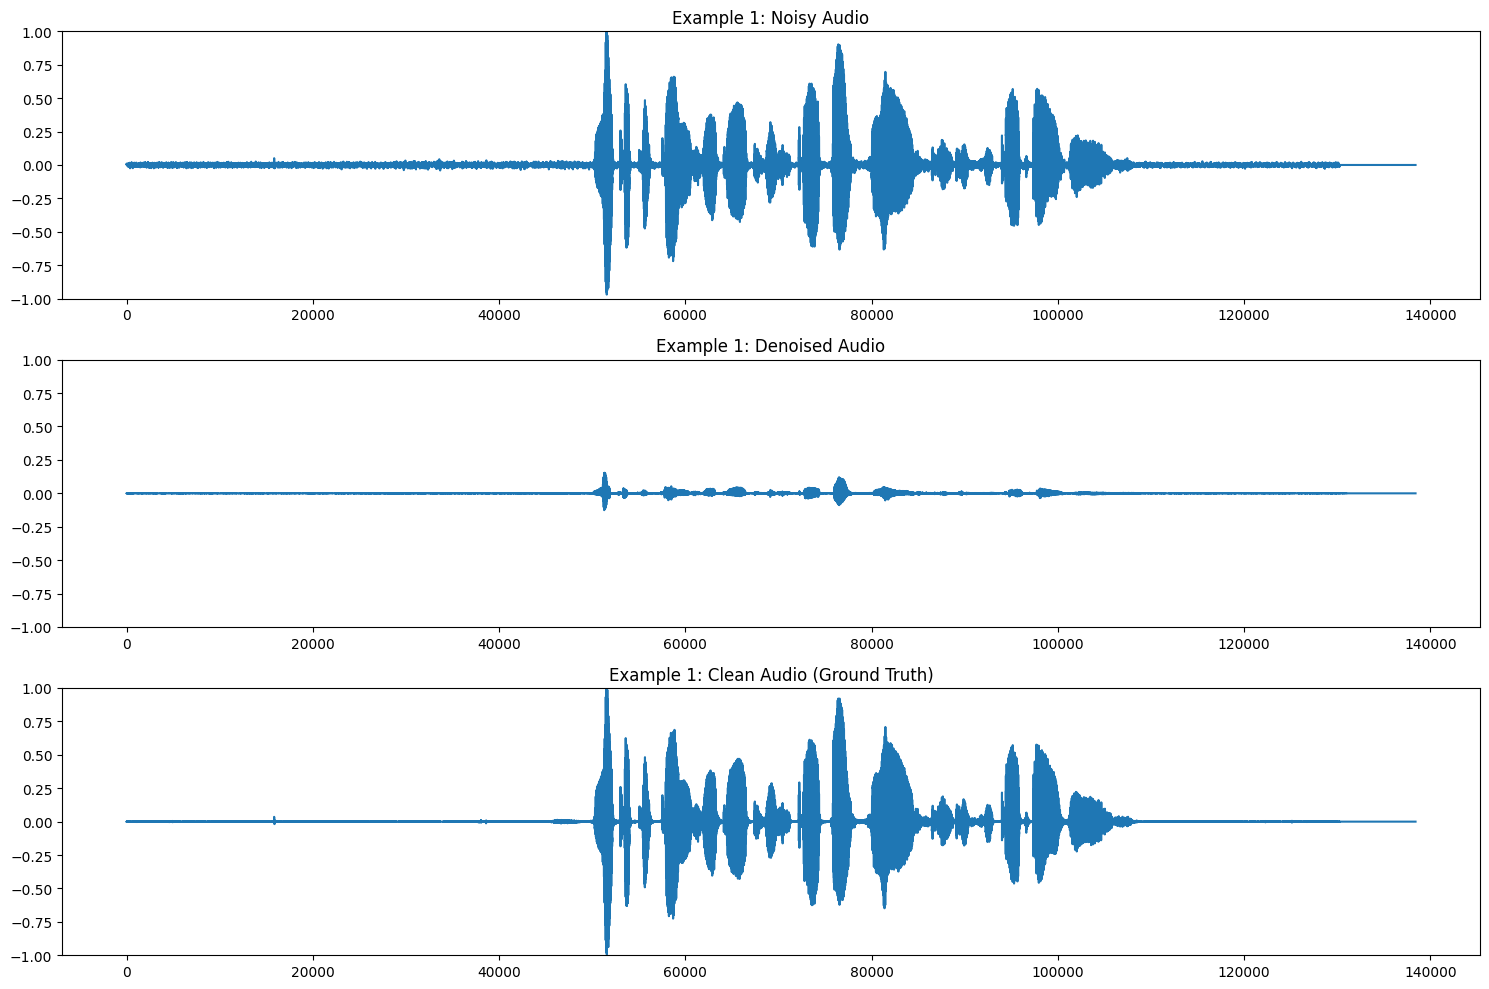


Example 1 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


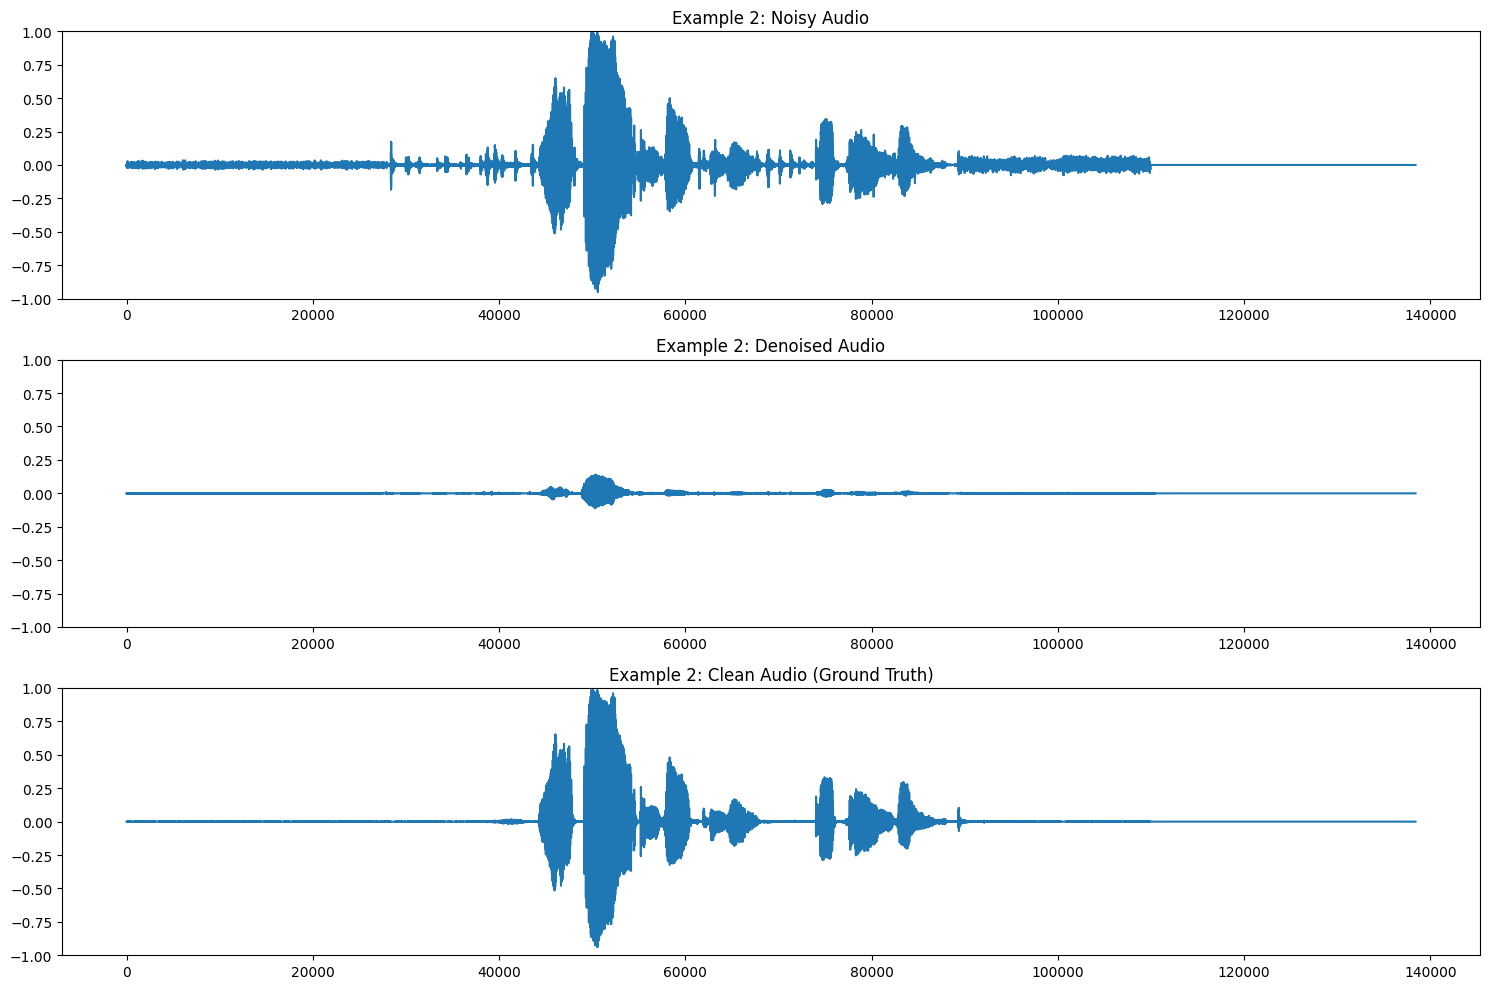


Example 2 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


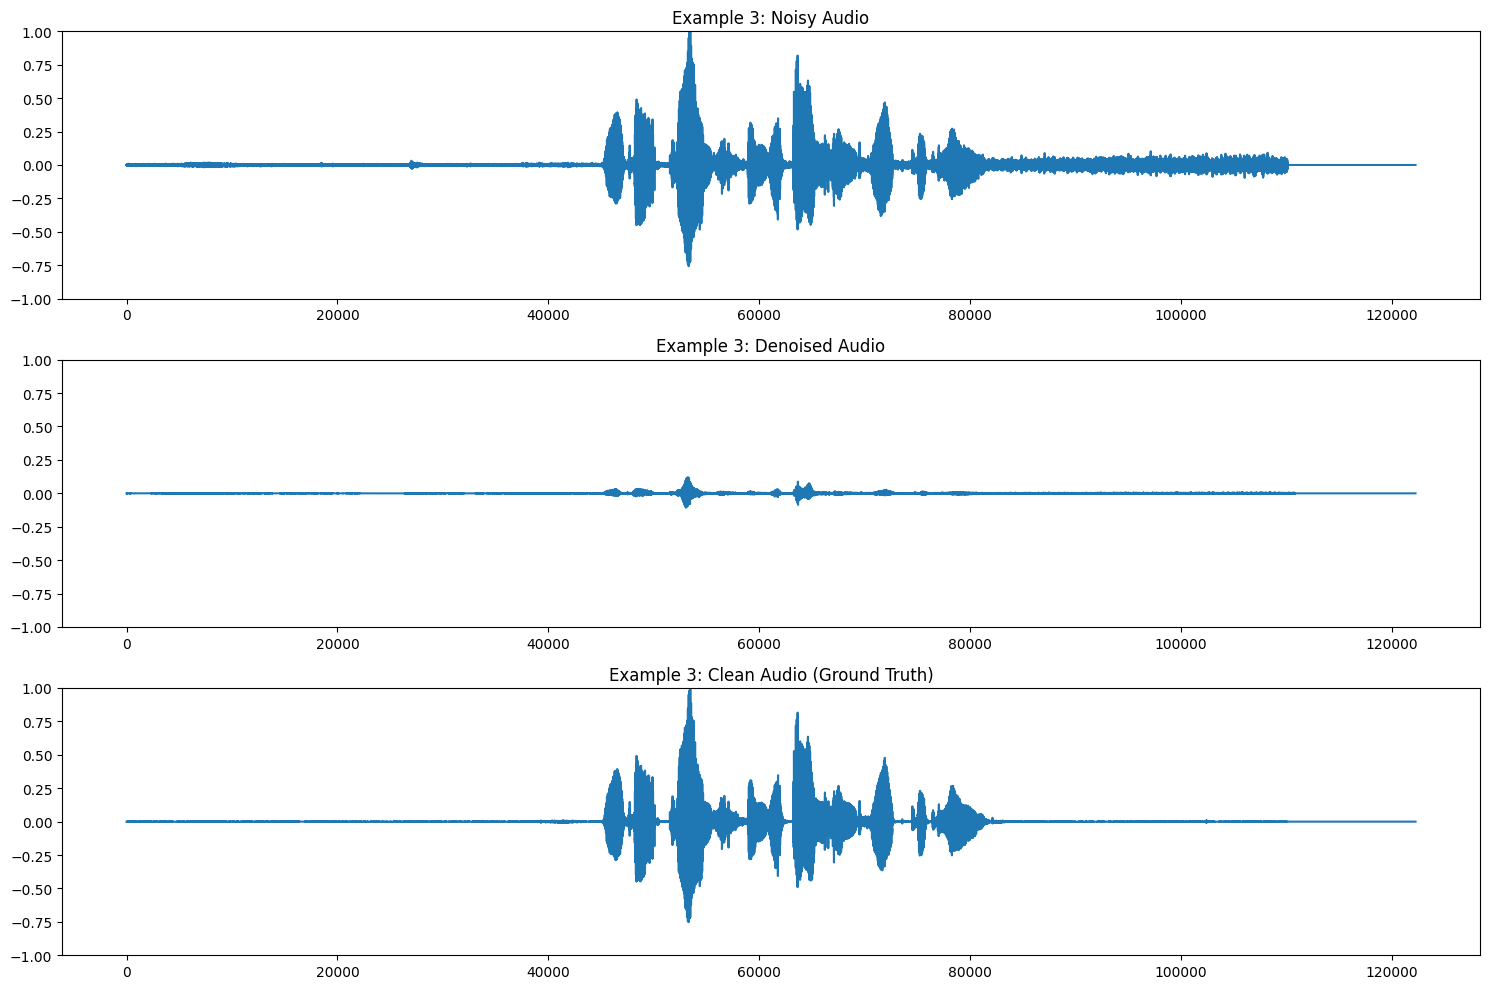


Example 3 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


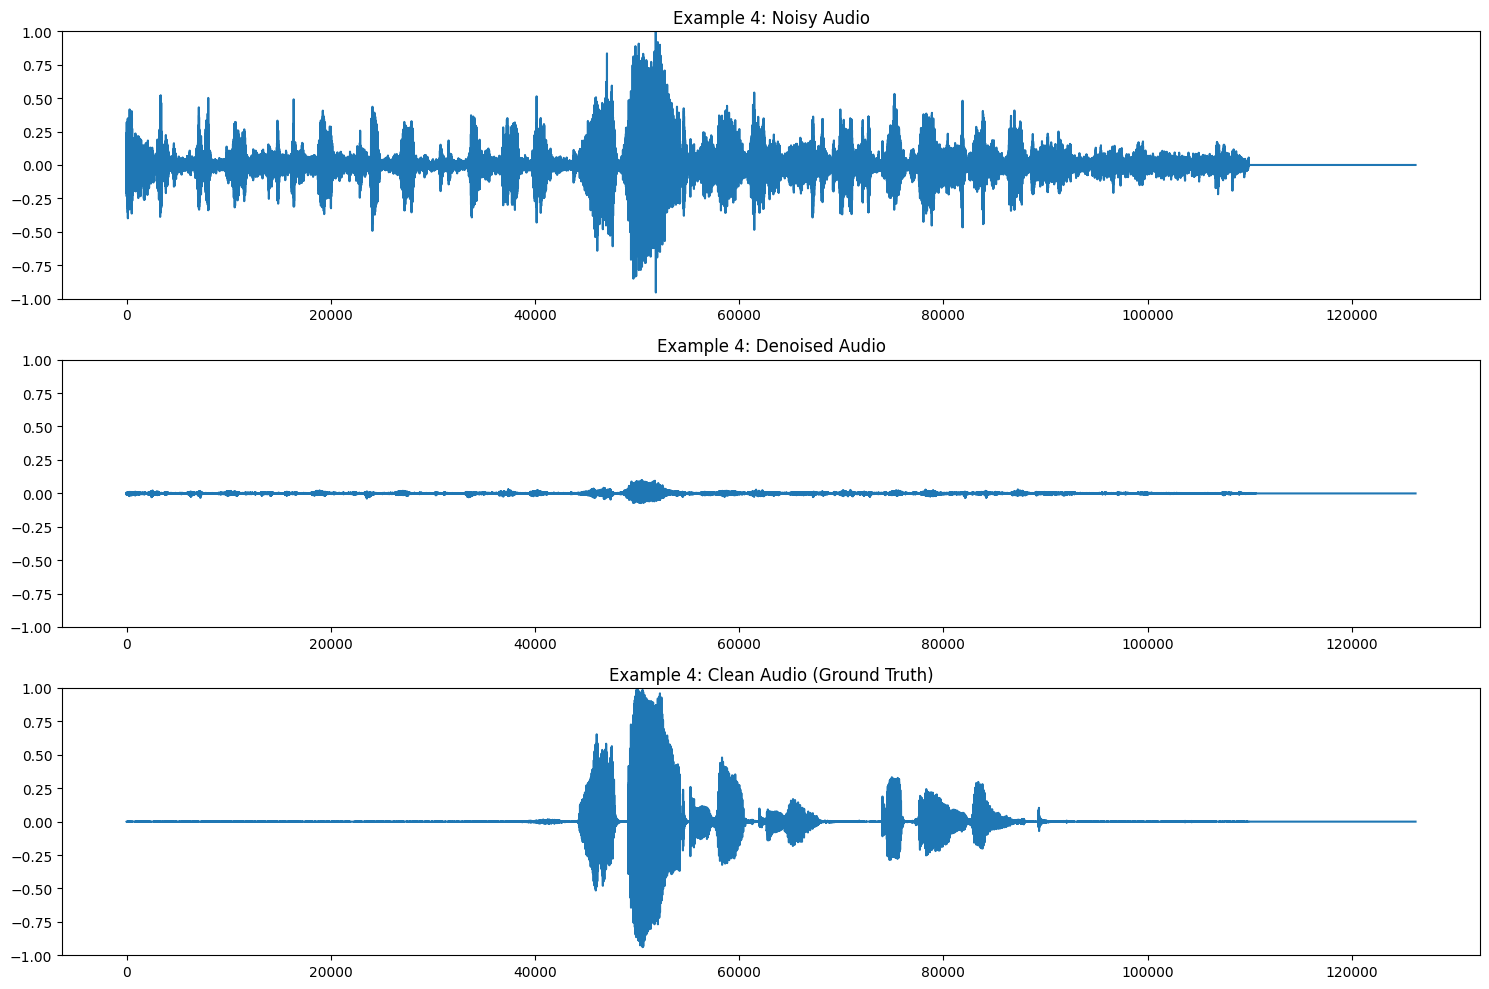


Example 4 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


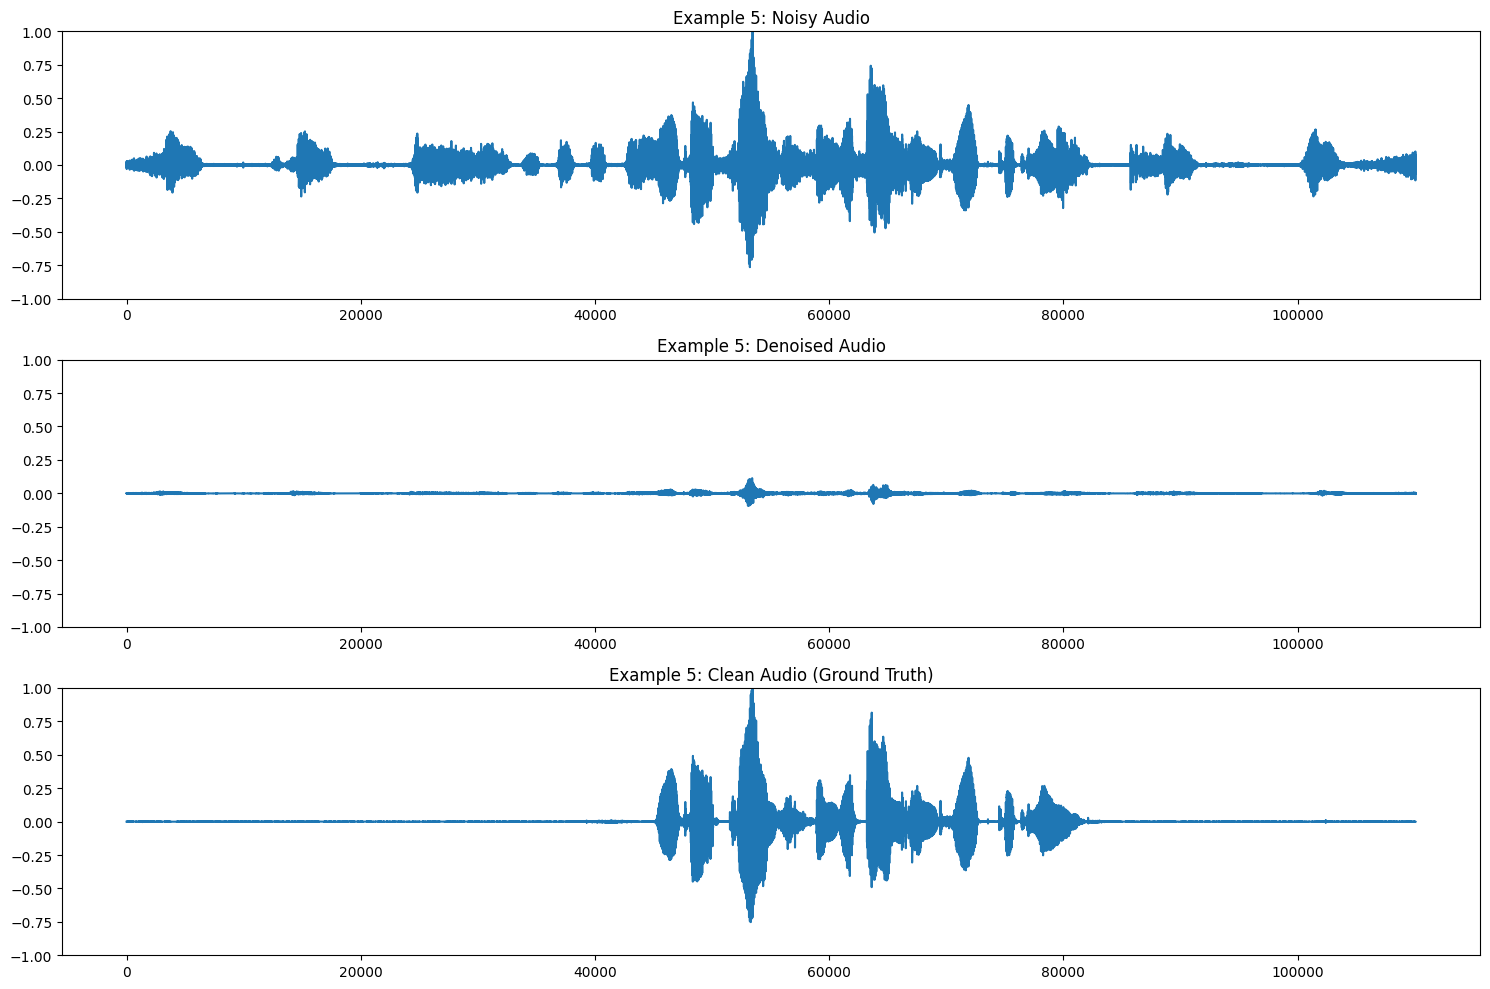


Example 5 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


In [12]:
import numpy as np
import matplotlib.pyplot as plt
def test_model(model, test_loader, criterion=None, save_examples=True, num_examples=5):
    """
    Test the denoising model and compute metrics
    
    Args:
        model: The trained model
        test_loader: DataLoader for test data
        criterion: Loss function (optional)
        save_examples: Whether to save example denoised files
        num_examples: Number of examples to visualize and save
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    test_loss = 0.0
    all_snr_before = []
    all_snr_after = []
    examples = []
    
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            noisy = batch['noisy'].unsqueeze(1).to(device)  # Add channel dimension
            clean = batch['clean'].unsqueeze(1).to(device)  # Add channel dimension
            
            
            # Forward pass
            denoised = model(noisy)
            
            # Store some examples
            if i < num_examples:
                examples.append({
                    'noisy': noisy[0].cpu().numpy().flatten(),
                    'clean': clean[0].cpu().numpy().flatten(),
                    'denoised': denoised[0].cpu().numpy().flatten()
                })
            
            # Calculate metrics
            if criterion:
                loss = criterion(denoised, clean)
                test_loss += loss.item() * noisy.size(0)
            
            # Calculate SNR before and after denoising
            for j in range(noisy.size(0)):
                # Original SNR
                noise = noisy[j].cpu().numpy() - clean[j].cpu().numpy()
                signal_power = np.mean(clean[j].cpu().numpy() ** 2)
                noise_power = np.mean(noise ** 2)
                snr_before = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')
                
                # SNR after denoising
                noise_after = denoised[j].cpu().numpy() - clean[j].cpu().numpy()
                noise_power_after = np.mean(noise_after ** 2)
                snr_after = 10 * np.log10(signal_power / noise_power_after) if noise_power_after > 0 else float('inf')
                
                all_snr_before.append(snr_before)
                all_snr_after.append(snr_after)
    
    # Calculate average metrics
    if criterion:
        avg_loss = test_loss / len(test_loader.dataset)
        print(f'Test Loss: {avg_loss:.6f}')
    
    avg_snr_before = np.mean(all_snr_before)
    avg_snr_after = np.mean(all_snr_after)
    snr_improvement = avg_snr_after - avg_snr_before
    
    print(f'Average SNR before denoising: {avg_snr_before:.2f} dB')
    print(f'Average SNR after denoising: {avg_snr_after:.2f} dB')
    print(f'Average SNR improvement: {snr_improvement:.2f} dB')
    
    # Visualize examples
    for i, example in enumerate(examples):
        plt.figure(figsize=(15, 10))
        
        # Plot waveforms
        plt.subplot(3, 1, 1)
        plt.plot(example['noisy'])
        plt.title(f'Example {i+1}: Noisy Audio')
        plt.ylim(-1, 1)
        
        plt.subplot(3, 1, 2)
        plt.plot(example['denoised'])
        plt.title(f'Example {i+1}: Denoised Audio')
        plt.ylim(-1, 1)
        
        plt.subplot(3, 1, 3)
        plt.plot(example['clean'])
        plt.title(f'Example {i+1}: Clean Audio (Ground Truth)')
        plt.ylim(-1, 1)
        
        plt.tight_layout()
        plt.show()
        
        # Create audio players
        sr = 16000  # Assuming 16kHz sample rate
        print(f"\nExample {i+1} - Audio playback:")
        
        print("Noisy Audio:")
        display(Audio(example['noisy'], rate=sr))
        
        print("Denoised Audio:")
        display(Audio(example['denoised'], rate=sr))
        
        print("Clean Audio (Ground Truth):")
        display(Audio(example['clean'], rate=sr))


    return {
        'loss': avg_loss if criterion else None,
        'snr_before': avg_snr_before,
        'snr_after': avg_snr_after,
        'snr_improvement': snr_improvement,
        'examples': examples
    }

#load the best model
model.load_state_dict(torch.load('../checkpoints/best_model_ddp.pth'))
# Run the test
test_results = test_model(model, test_loader, criterion)